<a href="https://colab.research.google.com/github/younghun-cha/Healthcare-Big-Data-Engineer/blob/main/AI/04-Deep_Learning_CNNs/03_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch CNN Transfer Learning: X-ray Image

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os

import torchvision
from torchvision import datasets, models
from torchvision import transforms

## 1. Data Visulization

In [4]:
base_path = "../dataset/x-ray/train/"

def load_images_from_folder(folder):
    
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images)>5:
            break
    
    plt.figure(figsize=(16,8))    
    for img,x in zip(images, range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

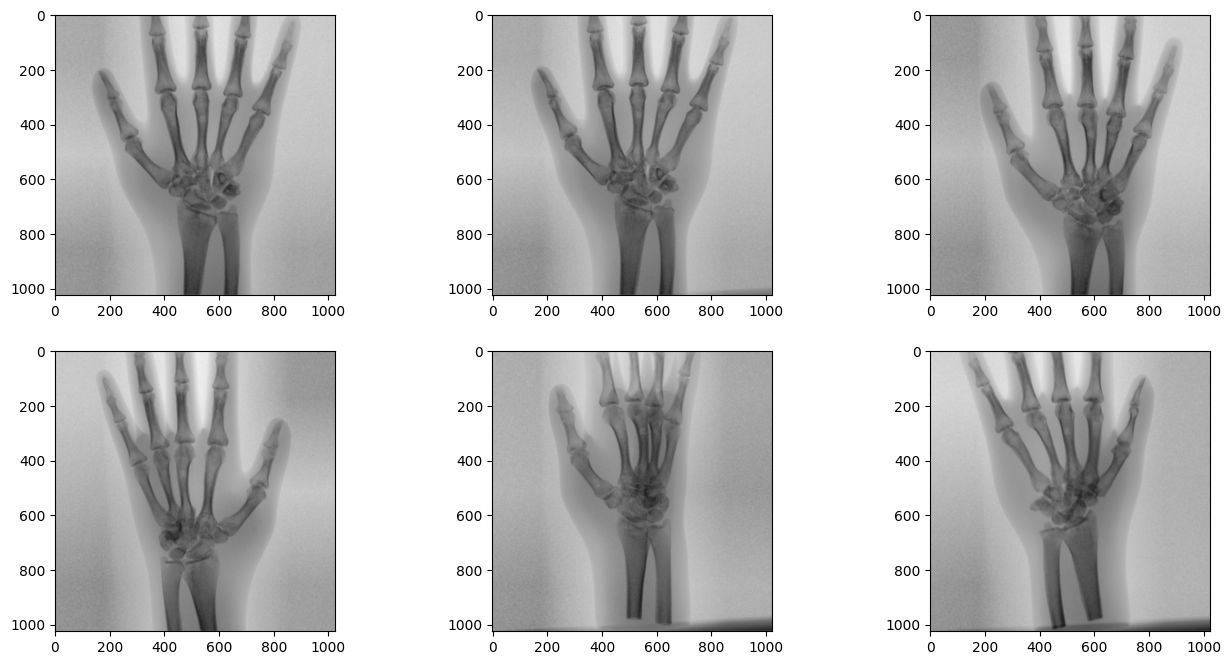

In [5]:
load_images_from_folder(base_path + "hand")

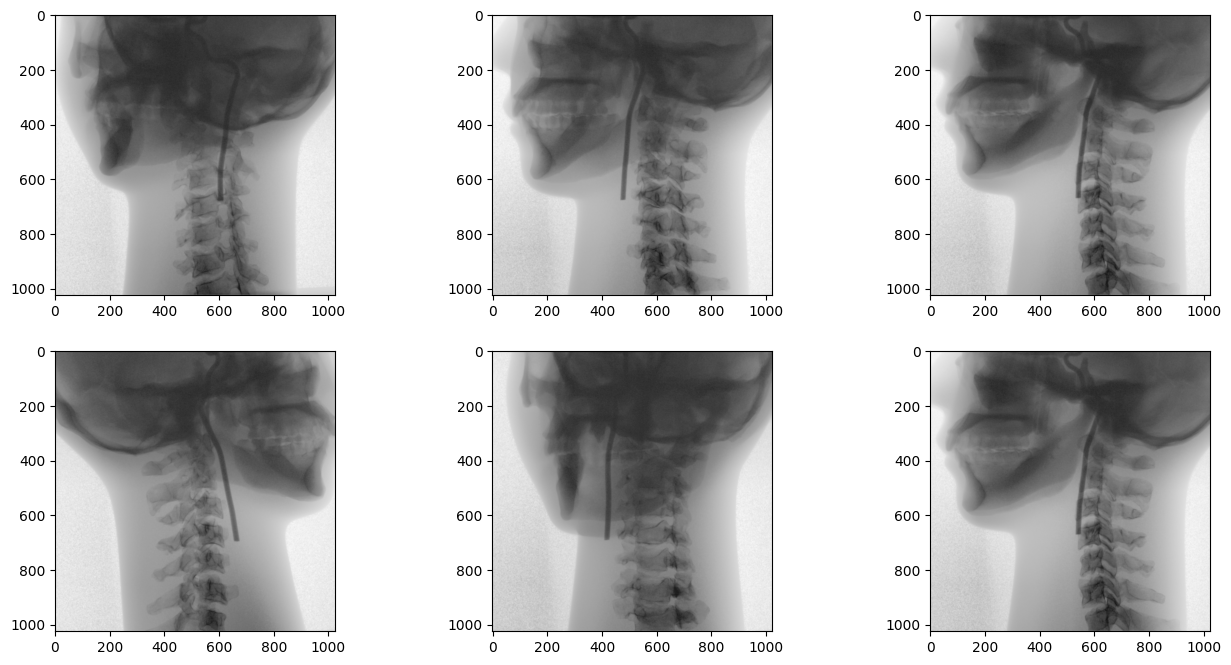

In [6]:
load_images_from_folder(base_path + "c-spine")

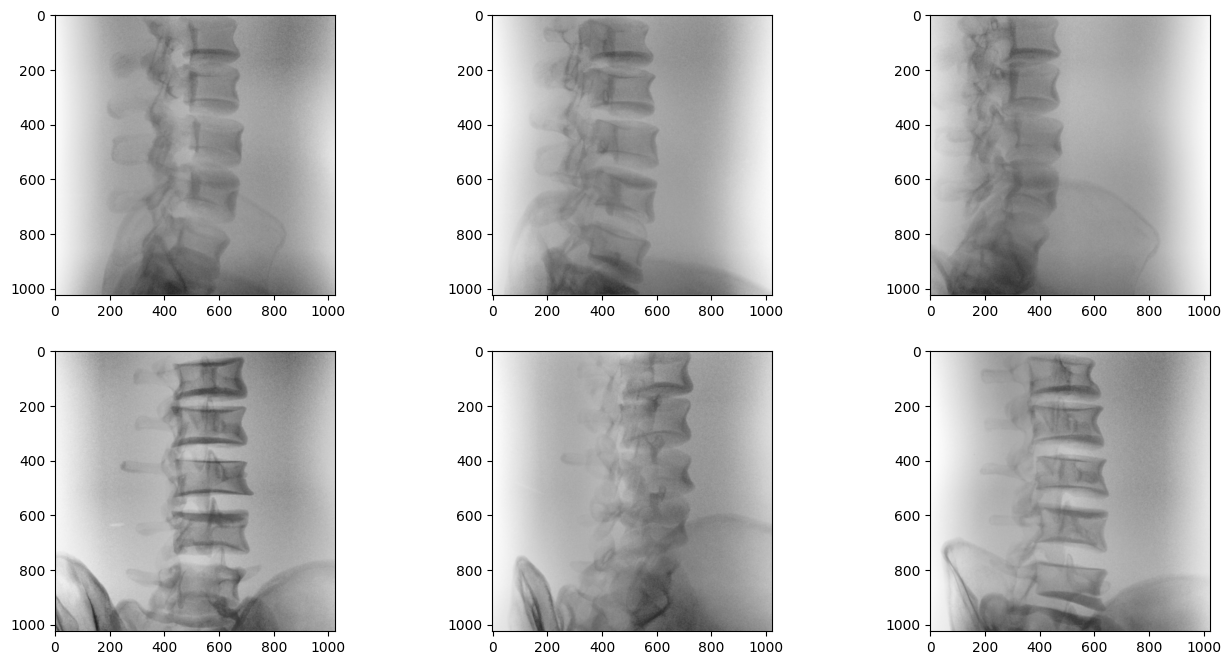

In [7]:
load_images_from_folder(base_path + "t-spine")

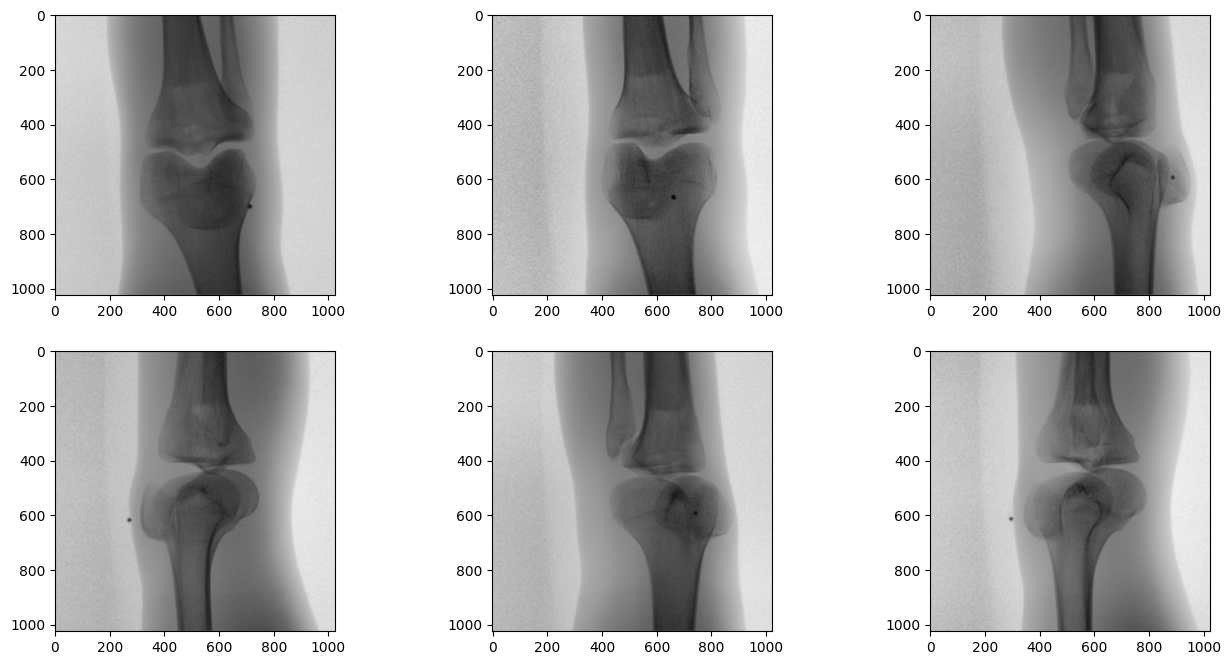

In [8]:
load_images_from_folder(base_path + "knee")

## 2. Data Processing

In [9]:
# Transforms에서 Data Augmentation, Tensor변환, Normalize 변환
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406], 
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])

In [10]:
train_dataset = datasets.ImageFolder(
          root='../dataset/x-ray/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(
            root='../dataset/x-ray/val',
            transform=val_transforms)

In [11]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=128,
            shuffle=True, 
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=128,
            shuffle=True, 
            num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3. Model Design: ResNet18

In [12]:
model = models.resnet18(pretrained=True)
print(model.fc)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
print(model.fc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=4, bias=True)


## 4. Training

In [13]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9) 

exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [14]:
num_epochs=25

for epoch in range(num_epochs):

  model.train()
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += \
        torch.sum(preds == labels.data)/inputs.size(0)

  exp_lr_scheduler.step()
  train_epoch_loss = running_loss / len(train_loader)
  train_epoch_acc = running_corrects / len(train_loader)

  model.eval() 
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in val_loader: 
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()/inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = running_corrects.double() / len(val_loader)
  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.0121 Acc: 0.2583 Val: Loss: 0.0432 Acc: 0.1500
Train: Loss: 0.0112 Acc: 0.3083 Val: Loss: 0.0410 Acc: 0.1750
Train: Loss: 0.0109 Acc: 0.3583 Val: Loss: 0.0387 Acc: 0.1750
Train: Loss: 0.0106 Acc: 0.3833 Val: Loss: 0.0365 Acc: 0.1250
Train: Loss: 0.0093 Acc: 0.6500 Val: Loss: 0.0344 Acc: 0.2250
Train: Loss: 0.0084 Acc: 0.8000 Val: Loss: 0.0321 Acc: 0.2750
Train: Loss: 0.0075 Acc: 0.8833 Val: Loss: 0.0297 Acc: 0.3750
Train: Loss: 0.0074 Acc: 0.7917 Val: Loss: 0.0292 Acc: 0.3750
Train: Loss: 0.0072 Acc: 0.8250 Val: Loss: 0.0288 Acc: 0.5250
Train: Loss: 0.0071 Acc: 0.8333 Val: Loss: 0.0284 Acc: 0.5000
Train: Loss: 0.0070 Acc: 0.8583 Val: Loss: 0.0281 Acc: 0.5500
Train: Loss: 0.0070 Acc: 0.8333 Val: Loss: 0.0277 Acc: 0.5750
Train: Loss: 0.0069 Acc: 0.8583 Val: Loss: 0.0272 Acc: 0.6000
Train: Loss: 0.0068 Acc: 0.8500 Val: Loss: 0.0267 Acc: 0.6500
Train: Loss: 0.0065 Acc: 0.9000 Val: Loss: 0.0265 Acc: 0.6750
Train: Loss: 0.0065 Acc: 0.9250 Val: Loss: 0.0262 Acc: 0.7000
Train: L

## 5. Testing and Deployment

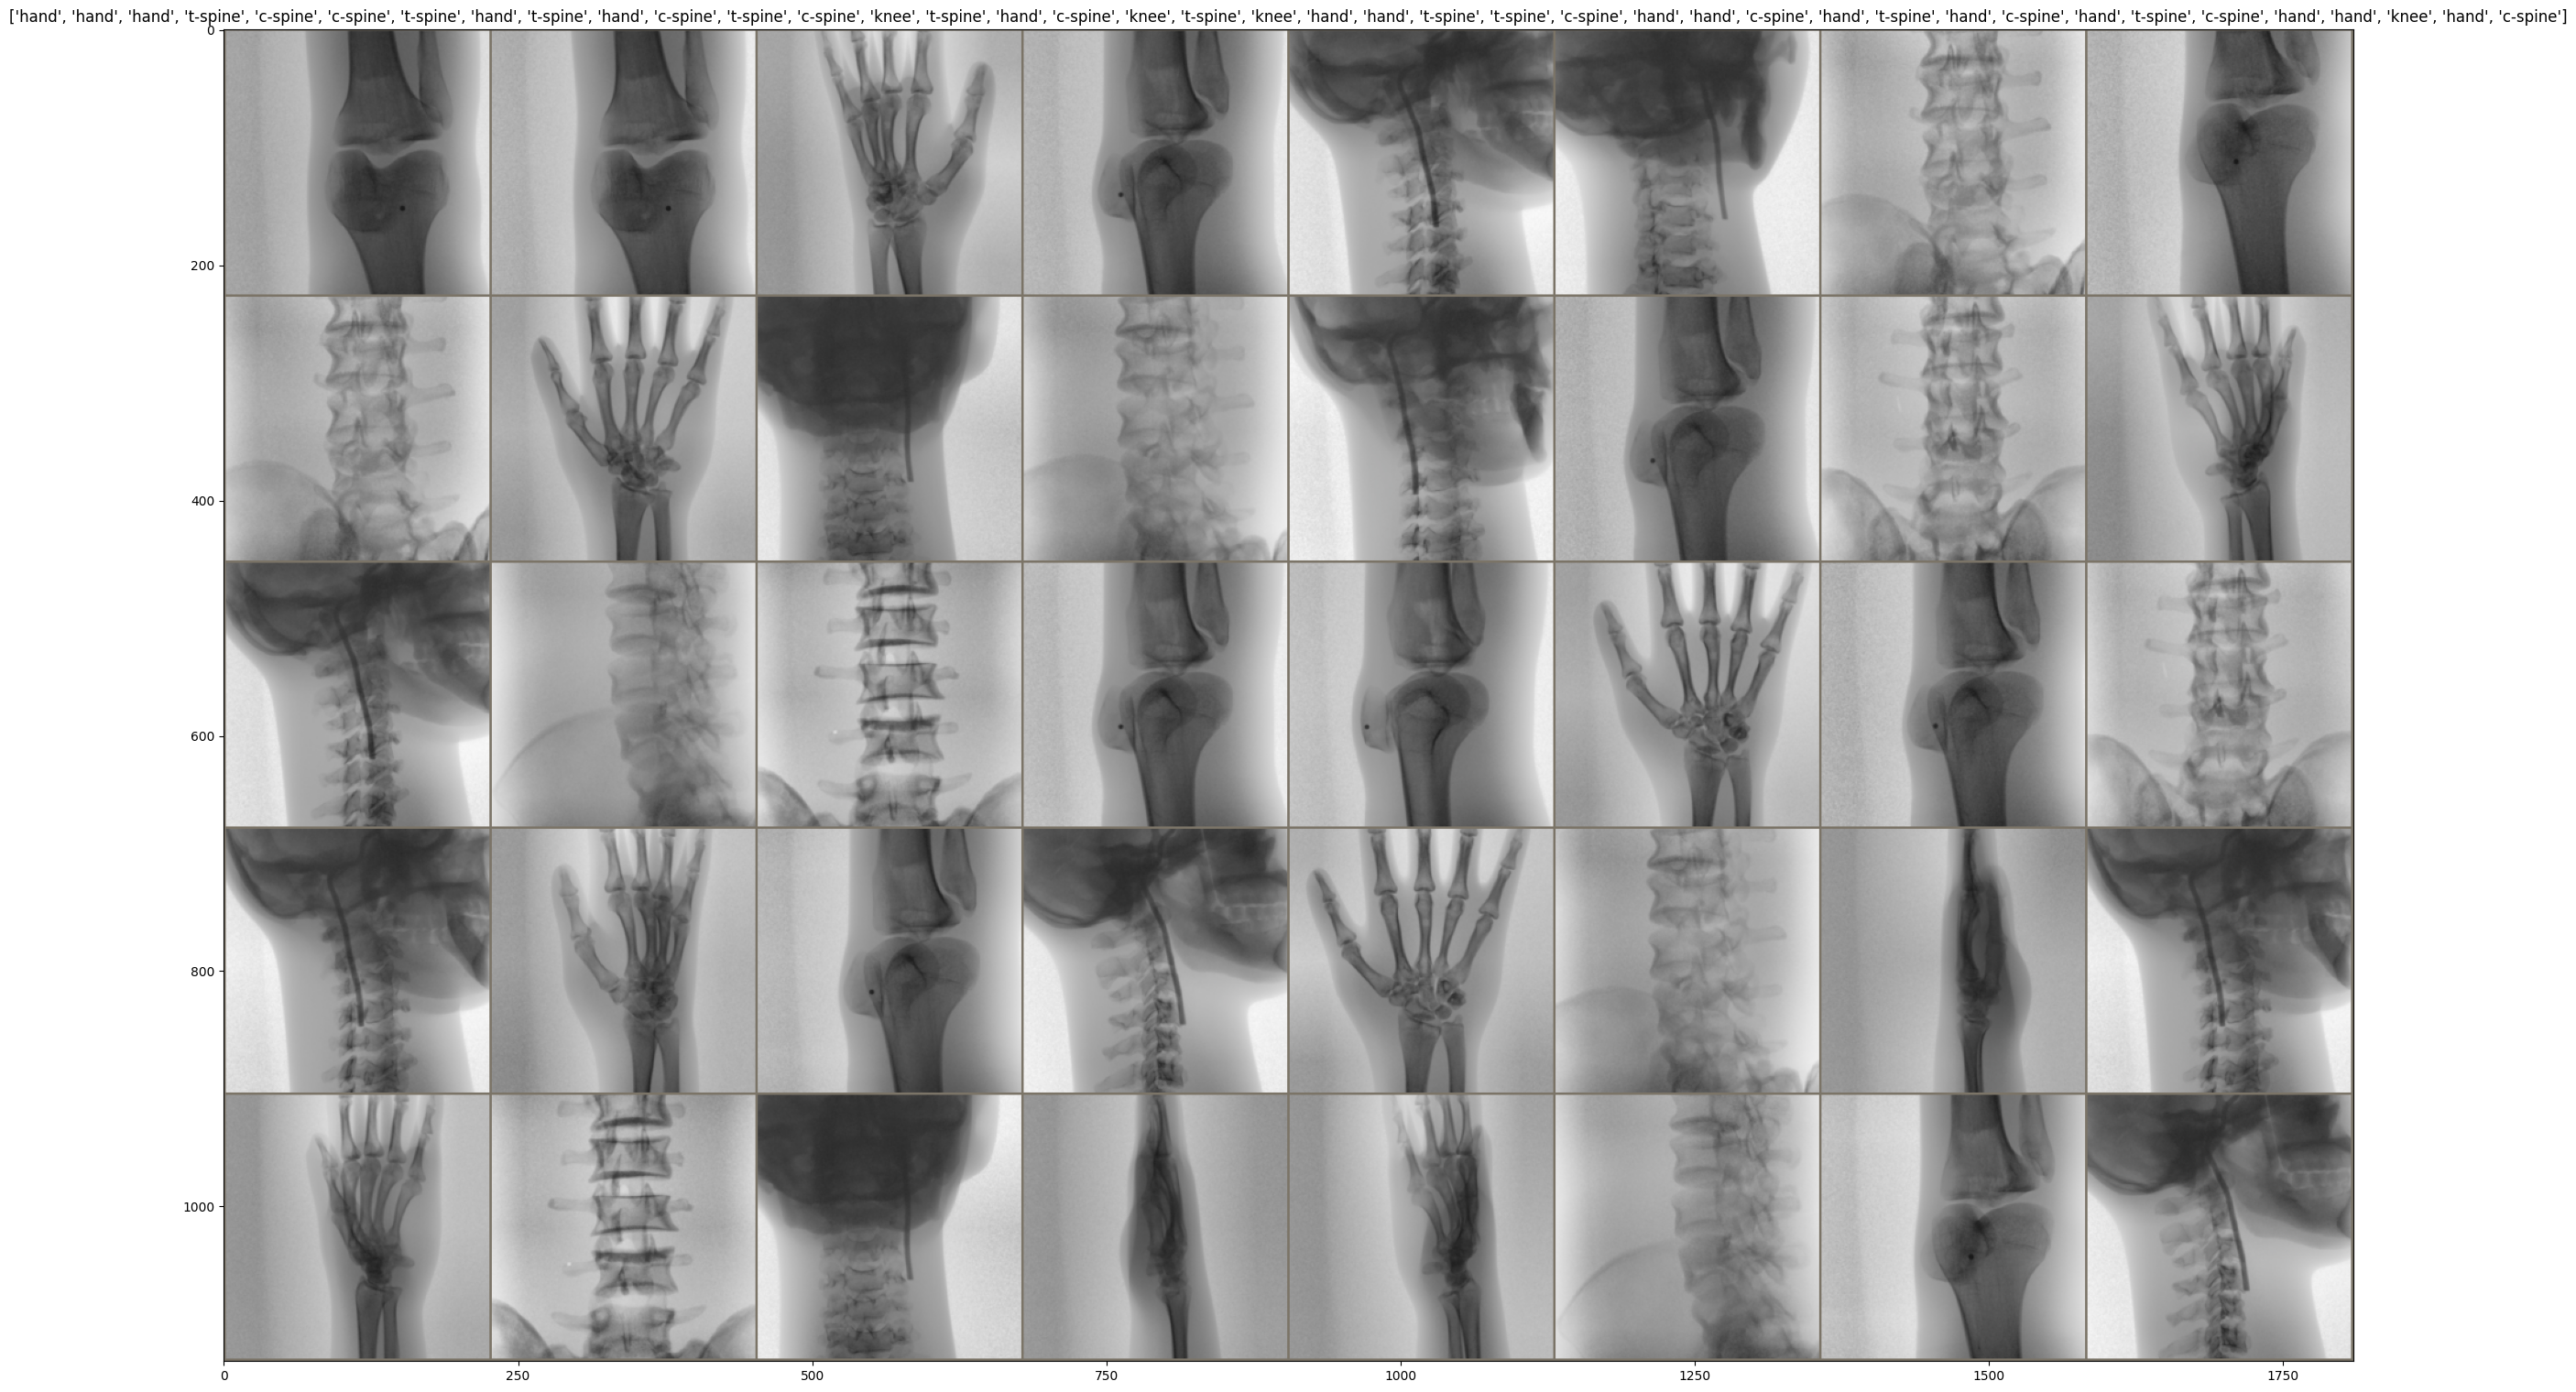

In [15]:
import matplotlib.pyplot as plt

def imshow(inp, title=None): 
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=[30, 30])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader)) 
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device)) 
_, preds = torch.max(outputs,1) 

imshow(out, title=[class_names[x] for x in preds]) 